<a href="https://colab.research.google.com/github/bijumanvya/Indix/blob/master/Codeblocks_with_results_jupyter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Curriculum Structure:-

Track 1: Core Time-Series Feature Engineering Concepts
(a small toy dataset)

Track 2: Finance Case Study – Stock Forecasting using RSI, MA, Bollinger
(Dataset: Yahoo Finance)

Track 3: Medical Case Study – Heart Rate Variability and Stress Detection
(Dataset: MIT-BIH)

Track 4: Comparative Forecasting Models – ARIMA vs LSTM
(Applied separately to both domains)

**Track 1**: Core Time-Series Feature Engineering Concepts
Dataset: Synthetic toy time-series data
Goal: Teach basic time-based, lag, rolling, window, and domain-specific features



In [ ]:
# 1. Setup and Data Generation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression  # Will be used later for modeling

# Generate a date range of 100 consecutive days starting from 2023-01-01
# 'D' frequency means daily data points
dates = pd.date_range(start='2023-01-01', periods=100, freq='D')

# Generate synthetic values using a random walk (cumulative sum of normal random values)
# This mimics time-series behavior like stock prices or temperature patterns
np.random.seed(0)  # Setting seed for reproducibility
values = np.cumsum(np.random.randn(100)) + 50  # Starting around 50 for base level

# Create a DataFrame using the generated dates and values
df = pd.DataFrame({'date': dates, 'value': values})

# Set the 'date' column as the index to enable time-based indexing
df.set_index('date', inplace=True)

# Display the first few rows of the dataset to confirm structure
df.head()


,value
date,
2023-01-01,51.764052
2023-01-02,52.164210
2023-01-03,53.142948
2023-01-04,55.383841
2023-01-05,57.251399


In [ ]:
# 2. Time-Based Features

# Extract the 'day' of the month from the datetime index (1 to 31)
# Useful for capturing trends or behaviors that vary by day of month
df['day'] = df.index.day

# Extract the 'weekday' where Monday=0 and Sunday=6
# Allows modeling of weekly seasonality or weekday-specific effects
df['weekday'] = df.index.weekday

# Extract the 'month' from the datetime index (1 to 12)
# Captures monthly seasonal effects or business cycle patterns
df['month'] = df.index.month

# Extract the ISO calendar week number (1 to 52)
# Useful in retail, energy, and sales data which often operate on a weekly cycle
df['weekofyear'] = df.index.isocalendar().week.astype(int)

# Create binary feature: 1 if the day is a weekend (Saturday or Sunday), else 0
# Helps the model learn behavior changes between weekends and weekdays
df['is_weekend'] = df['weekday'].isin([5, 6]).astype(int)

# Display the first few rows to verify time-based features
df.head()


,value,day,weekday,month,weekofyear,is_weekend
date,,,,,,
2023-01-01,51.764052,1,6,1,52,1
2023-01-02,52.164210,2,0,1,1,0
2023-01-03,53.142948,3,1,1,1,0
2023-01-04,55.383841,4,2,1,1,0
2023-01-05,57.251399,5,3,1,1,0


In [ ]:
# 3. Lag Features

# Create lag_1: value from the previous day
# Allows the model to learn from the most recent past observation
df['lag_1'] = df['value'].shift(1)

# Create lag_3: value from three days ago
# Helps the model identify short-term delayed effects
df['lag_3'] = df['value'].shift(3)

# Create lag_7: value from seven days ago
# Useful to capture weekly repeating patterns or weekly seasonality
df['lag_7'] = df['value'].shift(7)

# Display the current value and its lagged versions to inspect correctness
df[['value', 'lag_1', 'lag_3', 'lag_7']].head(10)

,value,lag_1,lag_3,lag_7
date,,,,
2023-01-01,51.764052,NaN,NaN,NaN
2023-01-02,52.164210,51.764052,NaN,NaN
2023-01-03,53.142948,52.164210,NaN,NaN
2023-01-04,55.383841,53.142948,51.764052,NaN
2023-01-05,57.251399,55.383841,52.164210,NaN
2023-01-06,56.274121,57.251399,53.142948,NaN
2023-01-07,57.224209,56.274121,55.383841,NaN
2023-01-08,57.072852,57.224209,57.251399,51.764052
2023-01-09,56.969633,57.072852,56.274121,52.164210


In [ ]:
# 4. Rolling Statistics

# Compute 7-day rolling mean: average of the current and previous 6 days
# Smooths out short-term fluctuations and highlights longer-term trends
df['roll_mean_7'] = df['value'].rolling(window=7).mean()

# Compute 7-day rolling standard deviation: measures variability over the last 7 days
# Helps model volatility or instability in the signal
df['roll_std_7'] = df['value'].rolling(window=7).std()

# Display the original value along with the rolling mean and std for inspection
df[['value', 'roll_mean_7', 'roll_std_7']].head(10)
#Detects trend smoothness and local variability. Great for anomaly detection.


,value,roll_mean_7,roll_std_7
date,,,
2023-01-01,51.764052,NaN,NaN
2023-01-02,52.164210,NaN,NaN
2023-01-03,53.142948,NaN,NaN
2023-01-04,55.383841,NaN,NaN
2023-01-05,57.251399,NaN,NaN
2023-01-06,56.274121,NaN,NaN
2023-01-07,57.224209,54.743540,2.355417
2023-01-08,57.072852,55.501940,2.074049
2023-01-09,56.969633,56.188429,1.501382


In [ ]:
# 5. Window-Based Feature: Rolling Slope

# Define a function to compute the slope (trend) over a rolling window using linear regression
# This captures the direction and strength of the trend over each window
def rolling_slope(series, window):
    slopes = [np.nan] * window  # First 'window' points will be NaN as there is not enough data
    for i in range(window, len(series)):
        y = series[i-window:i].values  # Target values over the window
        x = np.arange(window).reshape(-1, 1)  # Time steps as features: 0, 1, ..., window-1
        model = LinearRegression().fit(x, y)  # Fit a line to the windowed segment
        slopes.append(model.coef_[0])  # Store the slope (coefficient) of the fitted line
    return slopes

# Apply the rolling_slope function to 'value' column using a 7-day window
# A positive slope means upward trend; negative slope means downward trend
df['slope_7'] = rolling_slope(df['value'], window=7)

# Display original value and computed rolling slope for inspection
df[['value', 'slope_7']].head(15)


,value,slope_7
date,,
2023-01-01,51.764052,NaN
2023-01-02,52.164210,NaN
2023-01-03,53.142948,NaN
2023-01-04,55.383841,NaN
2023-01-05,57.251399,NaN
2023-01-06,56.274121,NaN
2023-01-07,57.224209,NaN
2023-01-08,57.072852,1.025312
2023-01-09,56.969633,0.849240


In [ ]:
# 6. Domain-Specific Simulations (Toy Features)

# Example 1: Simulated Peak Usage (e.g., electricity, water, internet, etc.)
# Adding a synthetic 'usage' feature that increases artificially on weekends
# Mimics real-world usage spikes typically seen during non-working days
df['usage'] = df['value'] + df['is_weekend'] * 5  # Adds 5 units to value on weekends

# Example 2: Simulated Heart Rate-Like Signal
# Creating a synthetic heart rate signal with sinusoidal pattern and noise
# Represents periodic biological signals (like heartbeats) with natural variability
df['hr_signal'] = 70 + 10 * np.sin(np.linspace(0, 6*np.pi, len(df))) + np.random.normal(0, 2, len(df))

# Display a few rows to verify domain-specific synthetic features
df[['value', 'is_weekend', 'usage', 'hr_signal']].head()


,value,is_weekend,usage,hr_signal
date,,,,
2023-01-01,51.764052,1,56.764052,73.766301
2023-01-02,52.164210,0,52.164210,69.196994
2023-01-03,53.142948,0,53.142948,71.175655
2023-01-04,55.383841,0,55.383841,77.345202
2023-01-05,57.251399,0,57.251399,74.554543


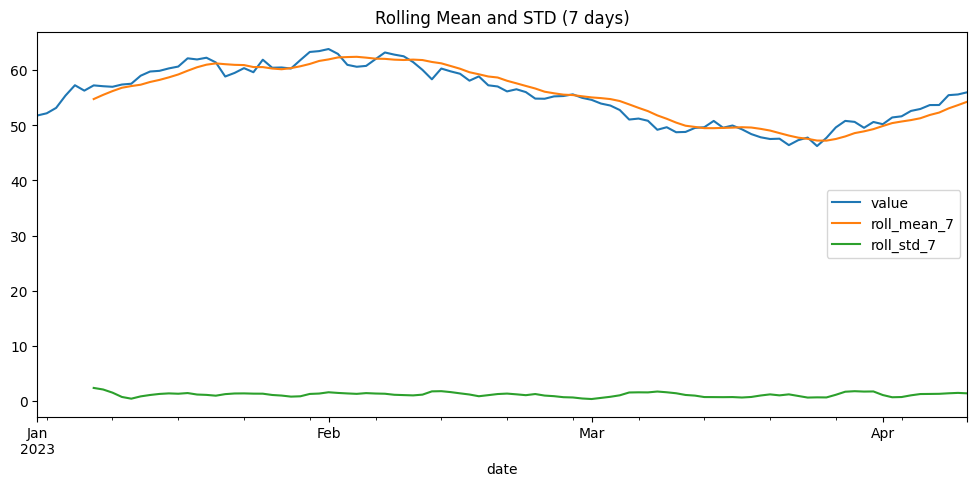

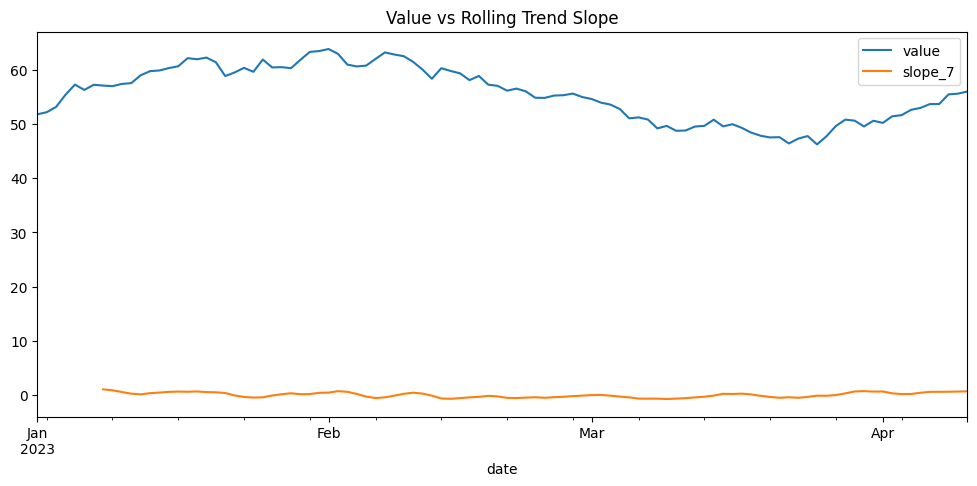

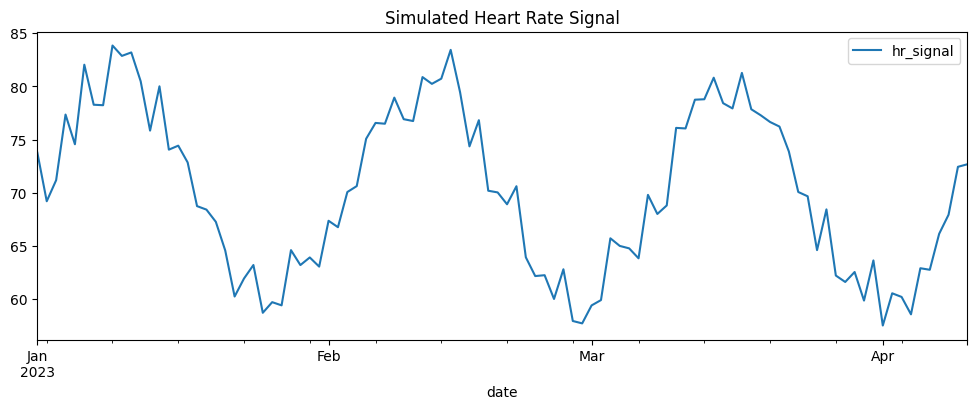

In [ ]:
# 7. Visualization

# Plotting the original value along with its 7-day rolling mean and standard deviation
# Interpretation: Rolling mean smooths out short-term noise and reveals underlying trend.
# Rolling standard deviation indicates the variability or volatility over the 7-day window.
df[['value', 'roll_mean_7', 'roll_std_7']].plot(figsize=(12, 5), title='Rolling Mean and STD (7 days)')
plt.show()

# Plotting the original value against the computed slope to visualize short-term trend direction
# Interpretation: A positive slope suggests an increasing trend, while a negative slope indicates a decline.
# This helps visualize momentum in the data.
df[['value', 'slope_7']].plot(figsize=(12, 5), title='Value vs Rolling Trend Slope')
plt.show()

# Plotting the simulated heart rate signal to demonstrate sinusoidal biomedical data
# Interpretation: This shows a smooth periodic pattern mimicking heart rate variability with added noise.
# Useful in healthcare for identifying stress, anomalies, or arrhythmia-like patterns.
df[['hr_signal']].plot(figsize=(12, 4), title='Simulated Heart Rate Signal')
plt.show()

# Summary Table for Module 1 Concepts:

# Feature Type       Examples                   Purpose
# Time-based        | day, weekday, month       | Detect seasonal and cyclical patterns
# Lag Features      | lag_1, lag_3, lag_7       | Capture autoregressive relationships
# Rolling Stats     | roll_mean_7, roll_std_7   | Track local trends and volatility
# Window-Based      | slope_7                   | Detect trend direction over time windows
# Domain-Specific   | usage, hr_signal          | Model real-world behavioral or physiological effects



**Track 2**: Finance Case Study – Stock Forecasting using RSI, MA, Bollinger
(Dataset: Yahoo Finance)
Goal: Use time-series feature engineering for forecasting and pattern recognition in stock prices
Dataset: Simulated Yahoo Finance (e.g., AAPL)

In [ ]:
# 1. Setup and Dataset Creation (Finance Case Study)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Generate a date range for 1 full year of business days (weekdays only)
# 'B' frequency excludes weekends and holidays — mimicking stock market calendars (as in Yahoo Finance)
dates_fin = pd.date_range(start='2022-01-01', end='2022-12-31', freq='B')

# Simulate synthetic stock closing prices using a random walk pattern
# This mirrors typical stock price behavior retrieved from Yahoo Finance APIs
np.random.seed(42)  # Set random seed for reproducibility
close_prices = np.cumsum(np.random.normal(0, 1, len(dates_fin))) + 150  # Base value set around 150

# Create a DataFrame with synthetic 'value' column representing closing price
df_fin = pd.DataFrame({'value': close_prices}, index=dates_fin)

# Rename the index to 'date' for clarity and time-based operations
df_fin.index.name = 'date'

# Display the first few rows of the synthetic financial time-series
df_fin.head()

# Interpretation:
# This code simulates a financial time-series dataset similar to one obtained from Yahoo Finance.
# It uses business-day frequency to reflect stock market schedules and applies a random walk to simulate realistic price movement.
# This dataset will serve as the foundation for calculating technical indicators like RSI, moving averages, and Bollinger Bands.


,value
date,
2022-01-03,150.496714
2022-01-04,150.358450
2022-01-05,151.006138
2022-01-06,152.529168
2022-01-07,152.295015


In [ ]:
# 2. Time-Based Features

# Extract the 'day' of the month from the datetime index (1 to 31)
# Helps in modeling behaviors that vary across different days of a month (e.g., end-of-month effects)
df_fin['day'] = df_fin.index.day

# Extract the 'weekday' (0=Monday, 6=Sunday) to capture weekly cyclic trends
# Weekday patterns are common in financial data (e.g., Monday dips, Friday rallies)
df_fin['weekday'] = df_fin.index.weekday

# Extract the 'month' from the datetime index (1 to 12)
# Useful for detecting seasonal investment behavior or monthly macro trends
df_fin['month'] = df_fin.index.month

# Extract the ISO calendar week number (1 to 52)
# Important in financial reporting cycles, especially for funds and earnings
df_fin['weekofyear'] = df_fin.index.isocalendar().week.astype(int)

# Create a binary indicator for weekends (1 if Saturday or Sunday, else 0)
# Though markets are closed on weekends, this can help when merged with other datasets (like volume or sentiment)
df_fin['is_weekend'] = df_fin['weekday'].isin([5, 6]).astype(int)

# Interpretation:
# These engineered time-based features allow models to learn temporal patterns like monthly trends,
# weekly cycles, and calendar-based seasonality in financial behavior.
# Even though stock markets don't operate on weekends, 'is_weekend' can still be useful in multi-source feature fusion (e.g., news data).

In [ ]:
# 3. Lag Features

# Create lag_1: Previous day's closing price
# This captures immediate temporal dependency, which is essential for autoregressive forecasting
df_fin['lag_1'] = df_fin['value'].shift(1)

# Create lag_3: Closing price from three business days ago
# Useful for learning short-term delayed effects or trends persisting across multiple days
df_fin['lag_3'] = df_fin['value'].shift(3)

# Create lag_7: Closing price from one week ago (7 business days prior)
# Helps the model identify weekly market patterns or seasonality
df_fin['lag_7'] = df_fin['value'].shift(7)

# Interpretation:
# Lag features are fundamental to time-series models as they introduce memory.
# They allow the model to recognize patterns and trends from past behavior.
# Including multiple lags (short and long) helps capture both recent momentum and periodic signals.


In [ ]:
# 4. Rolling Statistics

# Calculate the 7-day rolling mean (moving average)
# Smooths out short-term fluctuations and reveals underlying trends in stock prices
df_fin['roll_mean_7'] = df_fin['value'].rolling(window=7).mean()

# Calculate the 7-day rolling standard deviation
# Measures volatility or risk over the past 7 business days
df_fin['roll_std_7'] = df_fin['value'].rolling(window=7).std()

# Interpretation:
# Rolling mean is commonly used in technical analysis (like in Moving Average strategies)
# It helps identify bullish or bearish trends by comparing current price to historical average.
# Rolling standard deviation is a proxy for recent volatility — useful for risk-based decisions and Bollinger Band construction.


In [ ]:
# 5. Window-Based Feature: Trend Slope (Linear Regression over Rolling Window)

from sklearn.linear_model import LinearRegression

# Define a function to compute the slope (trend) within a rolling window
# This function fits a linear regression over every 7-day window and extracts the slope (direction of trend)
def rolling_slope(series, window):
    slopes = [np.nan] * window  # First 'window' values will have no slope due to insufficient data
    for i in range(window, len(series)):
        y = series[i-window:i].values  # Target variable over the rolling window
        x = np.arange(window).reshape(-1, 1)  # Time steps: 0, 1, ..., window-1
        model = LinearRegression().fit(x, y)  # Fit linear regression to the window
        slopes.append(model.coef_[0])  # Extract and store the slope (rate of change)
    return slopes

# Apply the slope function over a 7-day window to estimate local trends
# A positive slope means upward movement; negative slope indicates a downward trend
df_fin['slope_7'] = rolling_slope(df_fin['value'], window=7)

# Interpretation:
# This slope captures the local trend direction over a rolling 7-day window.
# It gives more nuanced insight than moving averages by quantifying how fast prices are rising or falling.
# This is particularly helpful in finance for identifying momentum, trend reversals, or confirming signals from other indicators.

In [ ]:
# 6. Domain-Specific Features – Moving Average (MA)

# Calculate 14-day simple moving average (MA)
# This is a widely used technical indicator in financial markets
# It smooths out price data to help identify trend direction and filter out noise
df_fin['ma_14'] = df_fin['value'].rolling(window=14).mean()

# Interpretation:
# Moving Average (MA) is a fundamental trend-following indicator.
# A rising MA indicates an uptrend, while a falling MA signals a downtrend.
# Traders often compare short-term MAs with long-term MAs to detect bullish or bearish crossovers.


In [ ]:
# 7. Domain-Specific Features – RSI (Relative Strength Index)

# Define a function to compute the Relative Strength Index (RSI)
# RSI measures the magnitude of recent price changes to evaluate overbought or oversold conditions
def compute_rsi(series, window=14):
    delta = series.diff()  # Difference between consecutive prices

    gain = delta.clip(lower=0)  # Keep only positive changes (gains)
    loss = -delta.clip(upper=0)  # Keep only negative changes (losses), and make them positive

    # Compute rolling averages of gains and losses over the specified window
    avg_gain = gain.rolling(window=window).mean()
    avg_loss = loss.rolling(window=window).mean()

    # Compute Relative Strength (RS) and then RSI
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))  # RSI is scaled between 0 and 100
    return rsi

# Apply RSI computation with a 14-day window
df_fin['rsi_14'] = compute_rsi(df_fin['value'])

# Interpretation:
# RSI is a momentum oscillator used to identify overbought (>70) or oversold (<30) market conditions.
# It is a key signal in technical analysis for anticipating price reversals or validating trend strength.
# A rising RSI indicates increasing bullish momentum, while a falling RSI shows bearish momentum.


In [ ]:
# 8. Domain-Specific Features – Bollinger Bands

# Calculate the upper Bollinger Band: 7-day rolling mean + 2 standard deviations
# This defines the upper limit of expected normal price variation
df_fin['bollinger_upper'] = df_fin['roll_mean_7'] + 2 * df_fin['roll_std_7']

# Calculate the lower Bollinger Band: 7-day rolling mean - 2 standard deviations
# This defines the lower limit of expected normal price variation
df_fin['bollinger_lower'] = df_fin['roll_mean_7'] - 2 * df_fin['roll_std_7']

# Interpretation:
# Bollinger Bands are used to detect volatility and potential price breakouts.
# When the price moves near or outside the bands, it may signal overbought (upper) or oversold (lower) conditions.
# The band width expands in high volatility and contracts in low volatility, providing visual cues for market behavior.

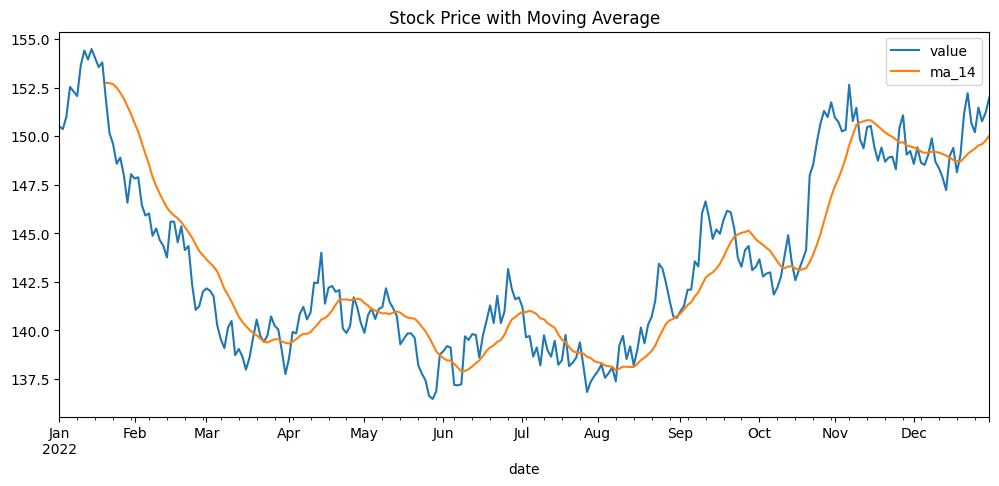

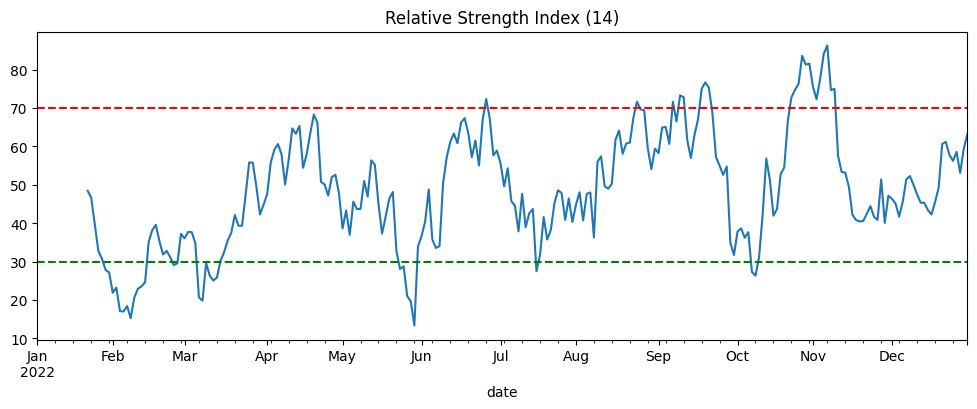

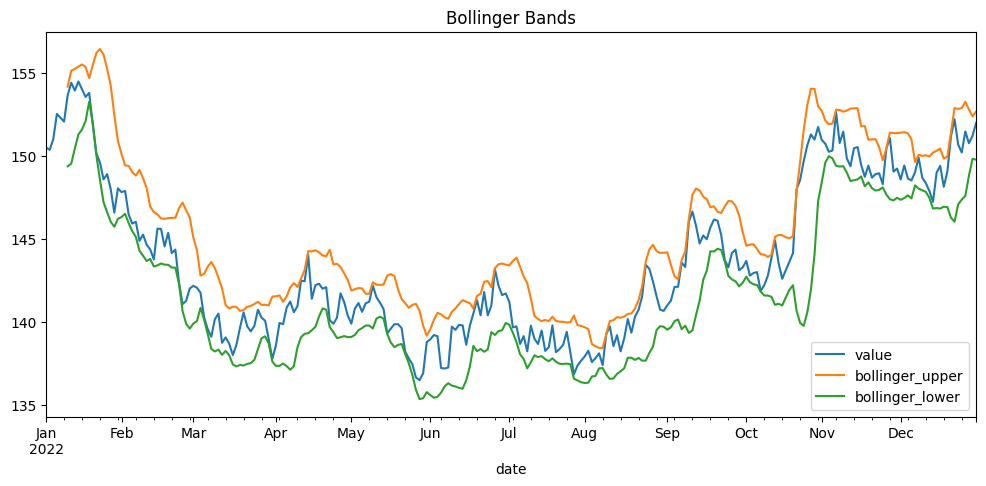

In [ ]:
# 9. Visualizations

# Plot stock price along with 14-day moving average
# This helps visually identify trends and possible crossover signals
df_fin[['value', 'ma_14']].plot(figsize=(12,5), title='Stock Price with Moving Average')
plt.show()

# Plot RSI with threshold lines at 70 and 30
# This visualizes momentum and overbought/oversold zones
df_fin['rsi_14'].plot(figsize=(12,4), title='Relative Strength Index (14)')
plt.axhline(70, color='red', linestyle='--')   # Overbought threshold
plt.axhline(30, color='green', linestyle='--') # Oversold threshold
plt.show()

# Plot stock price with upper and lower Bollinger Bands
# This shows volatility and potential reversal zones
df_fin[['value', 'bollinger_upper', 'bollinger_lower']].plot(figsize=(12,5), title='Bollinger Bands')
plt.show()

# Interpretation:
# - The moving average plot smooths out noise and highlights trend direction.
# - The RSI plot helps detect momentum shifts; crossings of 70 or 30 may indicate turning points.
# - The Bollinger Band plot highlights volatility; price touching or breaching bands can signal breakouts or reversals.
# Together, these visual tools support technical analysis and improve forecasting or trading decisions.

**Track 3**: Medical Case Study – Heart Rate Variability (HRV) and Stress Detection
Dataset: Simulated MIT-BIH ECG RR Interval Dataset
Goal: Demonstrate core time-series feature engineering on physiological signal data (ECG)

In [ ]:
# 1. Setup and Dataset Simulation

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Generate 100 days of synthetic R-R interval data (time between heartbeats in milliseconds)
# RR intervals typically vary with sinusoidal patterns due to physiological rhythms (e.g., breathing)
np.random.seed(101)  # Seed for reproducibility

# Create daily date range for 100 days starting from 2022-01-01
dates_med = pd.date_range(start='2022-01-01', periods=100, freq='D')

# Simulate RR intervals:
# Base heart rate interval around 800 ms,
# Modulated by a sinusoidal component representing natural variability,
# Plus some Gaussian noise to mimic measurement noise or physiological variation
rr_intervals = 800 + 50 * np.sin(np.linspace(0, 6 * np.pi, 100)) + np.random.normal(0, 10, 100)

# Construct a DataFrame with the simulated RR interval values indexed by date
df_med = pd.DataFrame({'value': rr_intervals}, index=dates_med)
df_med.index.name = 'date'

# Display first few rows of the simulated medical time-series data
df_med.head()

# Interpretation:
# This dataset mimics heart rate variability patterns found in MIT-BIH ECG data.
# It will be used to extract physiological features such as variability metrics and trends.


,value
date,
2022-01-01,827.068498
2022-01-02,815.743889
2022-01-03,827.662817
2022-01-04,832.070298
2022-01-05,841.015130


In [ ]:
# 2. Time-Based Features

# Extract the 'day' of the month (1-31) to capture daily patterns in heart rate variability
df_med['day'] = df_med.index.day

# Extract 'weekday' (0=Monday to 6=Sunday) to analyze weekly rhythms or stress patterns
df_med['weekday'] = df_med.index.weekday

# Extract 'month' (1-12) to detect possible monthly physiological cycles
df_med['month'] = df_med.index.month

# Extract ISO week number (1-52) to examine weekly trends or changes in heart rate
df_med['weekofyear'] = df_med.index.isocalendar().week.astype(int)

# Binary indicator for weekends (1 if Saturday or Sunday, else 0)
# Useful if heart rate variability differs on weekends due to lifestyle changes
df_med['is_weekend'] = df_med['weekday'].isin([5, 6]).astype(int)

# Interpretation:
# These features help capture temporal dependencies and periodicities in physiological signals.
# For example, stress or activity patterns may differ by day, week, or month, impacting heart rate variability.


In [ ]:
# 3. Lag Features

# Create lag_1: previous day's RR interval
# Enables the model to learn immediate temporal dependencies in heart rate variability
df_med['lag_1'] = df_med['value'].shift(1)

# Create lag_3: RR interval from three days ago
# Helps capture short-term physiological patterns or recovery cycles
df_med['lag_3'] = df_med['value'].shift(3)

# Create lag_7: RR interval from one week ago
# Useful for detecting weekly periodicities or long-term trends in heart function
df_med['lag_7'] = df_med['value'].shift(7)

# Interpretation:
# Lag features allow the model to leverage historical values to better predict current heart rate variability.
# These are crucial in time-series to capture autocorrelations and cyclical behaviors in physiological data.

In [ ]:
# 4. Rolling Statistics

# Calculate 7-day rolling mean of RR intervals
# Smooths out daily fluctuations and reveals underlying trends in heart rate variability
df_med['roll_mean_7'] = df_med['value'].rolling(window=7).mean()

# Calculate 7-day rolling standard deviation of RR intervals
# Measures short-term variability or irregularity in heart rhythm
df_med['roll_std_7'] = df_med['value'].rolling(window=7).std()

# Interpretation:
# Rolling mean highlights gradual shifts in average heart rate variability over time.
# Rolling standard deviation reflects periods of increased or decreased physiological variability,
# which can be indicative of stress, recovery, or health status changes.

In [ ]:
# 5. Window-Based Feature: Rolling Trend Slope

# Define a function to compute the slope of RR intervals over a rolling window using linear regression
# This captures the direction and strength of trends in heart rate variability over time
def rolling_slope(series, window):
    slopes = [np.nan] * window  # Initial values set to NaN due to insufficient data for window
    for i in range(window, len(series)):
        y = series[i-window:i].values  # RR interval values in current window
        x = np.arange(window).reshape(-1, 1)  # Time index for regression
        model = LinearRegression().fit(x, y)  # Fit linear model to window data
        slopes.append(model.coef_[0])  # Append the slope coefficient
    return slopes

# Apply the rolling slope calculation with a 7-day window
df_med['slope_7'] = rolling_slope(df_med['value'], window=7)

# Interpretation:
# Positive slope indicates increasing RR intervals (slower heart rate trend),
# while negative slope indicates decreasing RR intervals (faster heart rate trend).
# This feature helps detect short-term physiological changes or stress responses.


In [ ]:
# 6. Domain-Specific Features – Heart Rate Variability (HRV) Metrics

# RMSSD (Root Mean Square of Successive Differences) calculation:
# Measures short-term variability between consecutive RR intervals, reflecting parasympathetic nervous system activity
def compute_rmssd(series):
    diff = series.diff()  # Successive differences between RR intervals
    squared_diff = diff ** 2  # Square the differences to emphasize larger variations
    rmssd = np.sqrt(squared_diff.rolling(window=7).mean())  # Rolling mean then square root for 7-day window
    return rmssd

# Apply RMSSD calculation with a 7-day rolling window
df_med['rmssd_7'] = compute_rmssd(df_med['value'])

# Calculate instantaneous heart rate (beats per minute) from RR intervals (in milliseconds)
# HR = 60000 / RR_interval (ms), since 60000 ms = 1 minute
df_med['heart_rate'] = 60000 / df_med['value']

# Interpretation:
# RMSSD is a widely used HRV metric indicating parasympathetic (relaxation) activity.
# High RMSSD values suggest a relaxed state, while low values may indicate stress or fatigue.
# Instantaneous heart rate derived from RR intervals provides a direct physiological measure for health monitoring.


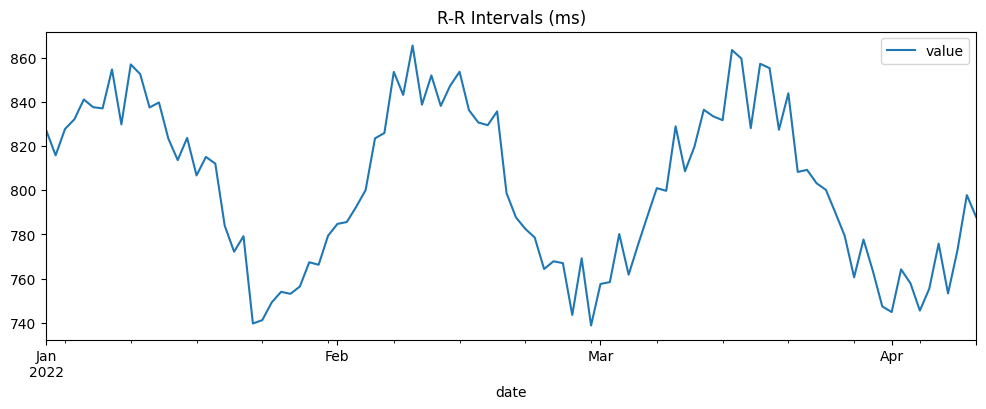

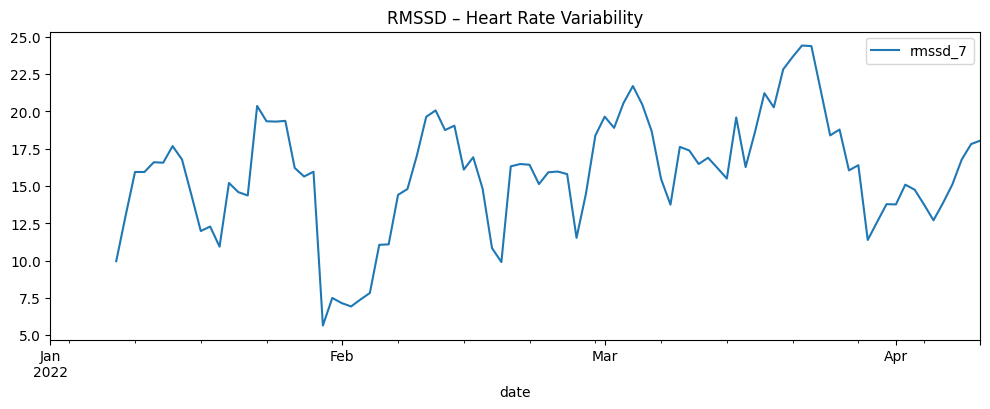

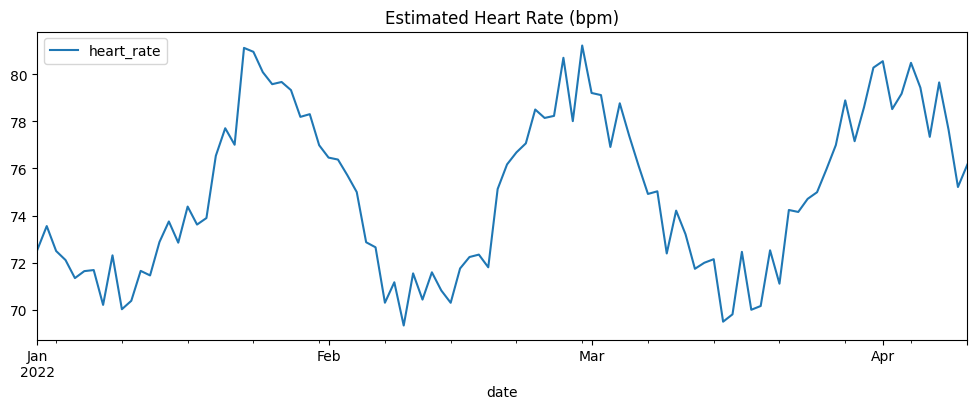

In [ ]:
# 7. Visualizations

# Plot the raw R-R intervals to observe heart rate timing variations over 100 days
df_med[['value']].plot(figsize=(12, 4), title='R-R Intervals (ms)')
plt.show()

# Plot RMSSD to visualize short-term heart rate variability trends
# Higher RMSSD values indicate greater variability and typically better autonomic health
df_med[['rmssd_7']].plot(figsize=(12, 4), title='RMSSD – Heart Rate Variability')
plt.show()

# Plot estimated heart rate derived from R-R intervals
# Allows tracking of heart rate fluctuations and physiological state changes over time
df_med[['heart_rate']].plot(figsize=(12, 4), title='Estimated Heart Rate (bpm)')
plt.show()

# Interpretation:
# - The R-R interval plot shows the fundamental timing between heartbeats.
# - RMSSD plot highlights variability which correlates with relaxation or stress.
# - Heart rate plot converts timing into beats per minute, a clinically relevant metric.
# Together, these visualizations provide comprehensive insight into cardiovascular dynamics.

**Track 4**: Comparative Forecasting Models – ARIMA vs LSTM
Apply ARIMA and LSTM to both domains:

Finance (Stock Prices)

Medical (RR Intervals)

In [ ]:
#  Setup – Prepare Environment for ARIMA vs LSTM Comparison

import numpy as np
from statsmodels.tsa.arima.model import ARIMA  # For traditional statistical time-series modeling
from sklearn.metrics import mean_absolute_error, mean_squared_error  # Evaluation metrics
from sklearn.preprocessing import MinMaxScaler  # Scaling data for neural networks
from keras.models import Sequential  # Neural network model container
from keras.layers import LSTM, Dense  # LSTM layers and output layers for deep learning model
import matplotlib.pyplot as plt  # Visualization

# Assumptions:
# df_fin - Cleaned stock price data from Track 2, with 'value' column as target
# df_med - Cleaned RR interval data from Track 3, with 'value' column as target

# These datasets will be used to build and compare forecasting models (ARIMA and LSTM)


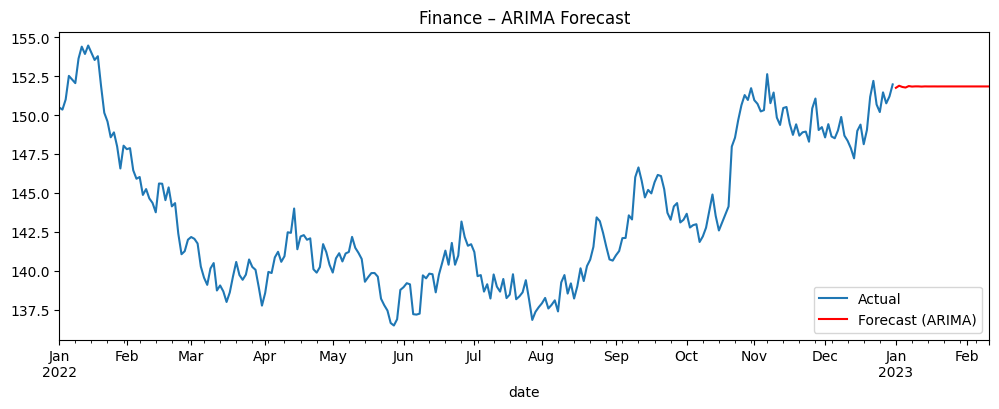

In [ ]:
# PART A – Forecasting on Finance Data (Stock Price)
# A1:- ARIMA Model on Stock Price Data

series_fin = df_fin['value'].asfreq('B').ffill()

model_arima_fin = ARIMA(series_fin, order=(5, 1, 0))
model_fit_fin = model_arima_fin.fit()

forecast_fin_arima = model_fit_fin.forecast(steps=30)

series_fin.plot(label='Actual', figsize=(12, 4))
forecast_fin_arima.plot(label='Forecast (ARIMA)', color='red')
plt.title('Finance – ARIMA Forecast')
plt.legend()
plt.show()

# Interpretation:
# ARIMA models capture linear dependencies and trends in stock prices.
# The forecasted 30-day price shows the model’s expected trajectory based on historical data.
# ARIMA’s strength is interpretability but may struggle with complex nonlinear patterns.

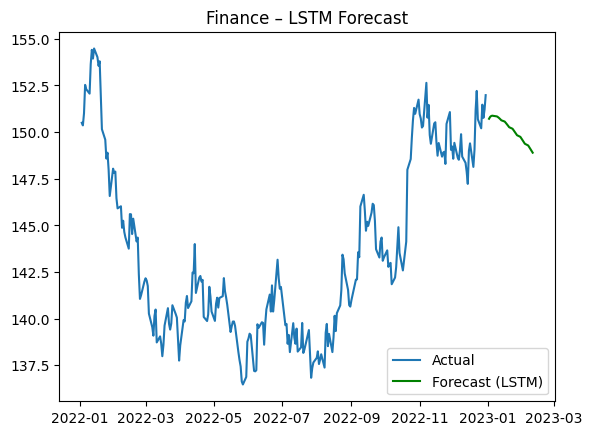

In [ ]:
# A2:- LSTM Forecasting on Finance Data (AAPL Stock)

# Normalize the stock price data to range [0, 1] for better neural network performance
scaler_fin = MinMaxScaler()
scaled_fin = scaler_fin.fit_transform(series_fin.values.reshape(-1, 1))
# Reshape (-1,1) because MinMaxScaler expects 2D input; scaled_fin contains normalized prices

# Create input sequences and targets for supervised learning
X_fin, y_fin = [], []
window = 30  # Use past 30 days to predict the next day
for i in range(window, len(scaled_fin)):
    X_fin.append(scaled_fin[i - window:i])  # Sequence of previous 30 normalized values as input
    y_fin.append(scaled_fin[i])              # Target is the next day's normalized value

# Convert lists to numpy arrays for model compatibility
X_fin, y_fin = np.array(X_fin), np.array(y_fin)

# Build LSTM model architecture
from tensorflow.keras.layers import Input

model_fin = Sequential()
model_fin.add(Input(shape=(X_fin.shape[1], 1)))  # Explicit Input layer specifying input shape (30 timesteps, 1 feature)
model_fin.add(LSTM(50))                          # LSTM layer with 50 units; input_shape removed as Input layer is present
model_fin.add(Dense(1))                          # Dense layer to predict next day's price value

model_fin.compile(loss='mse', optimizer='adam')  # Compile model with Mean Squared Error loss and Adam optimizer

# Train the LSTM model quietly for 10 epochs with batch size 16
model_fin.fit(X_fin, y_fin, epochs=10, batch_size=16, verbose=0)

# Forecast the next 30 days
input_seq = scaled_fin[-window:].reshape(1, window, 1)  # Start with the last observed 30 days, reshaped to (1,30,1)
forecast_fin_lstm = []  # Initialize empty list to store predicted normalized values

for _ in range(30):
    next_val = model_fin.predict(input_seq, verbose=0)[0][0]  # Predict the next day's normalized value
    forecast_fin_lstm.append(next_val)                        # Append predicted value to forecast list
    # Update the input sequence by removing the oldest value and appending the new prediction
    input_seq = np.append(input_seq[:, 1:, :], [[[next_val]]], axis=1)
    # This keeps input_seq shape as (1, 30, 1) for next prediction step

# Inverse transform the normalized forecasts back to original price scale
forecast_fin_lstm = scaler_fin.inverse_transform(np.array(forecast_fin_lstm).reshape(-1, 1))

# Plot actual stock prices and LSTM forecast
plt.plot(series_fin, label='Actual')  # Plot historical actual stock prices
plt.plot(pd.date_range(series_fin.index[-1], periods=31, freq='B')[1:], forecast_fin_lstm, label='Forecast (LSTM)', color='green')
# Plot forecasted prices for next 30 business days
plt.title('Finance – LSTM Forecast')
plt.legend()
plt.show()

# Interpretation:
# - Normalization rescales data to [0,1], improving neural network training stability.
# - The LSTM uses past 30 days of stock prices to predict future values, capturing complex temporal dependencies.
# - The forecast shows expected future stock prices over the next 30 business days.
# - LSTM can model nonlinear patterns and adapt to volatility better than traditional methods.
# - Visualization compares actual historical prices with LSTM predicted future trend.

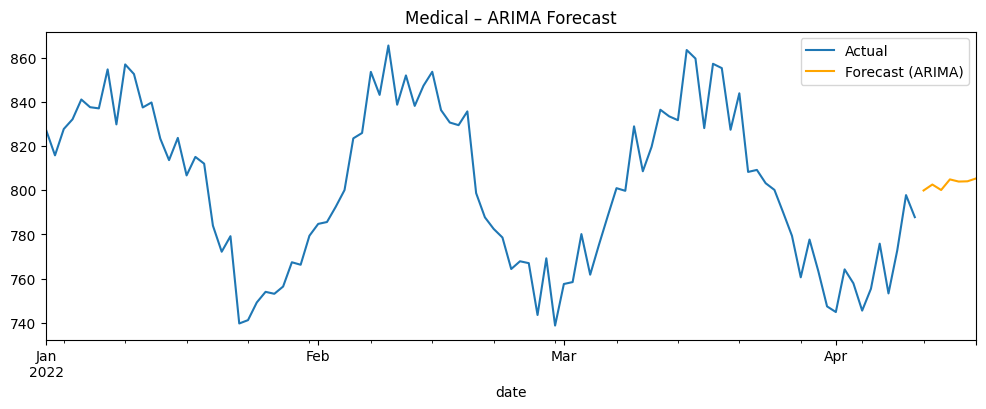

In [ ]:
# PART B – Forecasting on Medical Data (RR Intervals)
# B1:- ARIMA Model on ECG RR Intervals (Heartbeat Timing)

# Ensure the time series has daily frequency and handle any missing values with forward fill
series_med = df_med['value'].asfreq('D').ffill()

# Initialize and fit ARIMA model
# order=(3, 1, 0):
# p=3 (lag terms), d=1 (difference to make data stationary), q=0 (no moving average term)
model_arima_med = ARIMA(series_med, order=(3, 1, 0))
model_fit_med = model_arima_med.fit()

# Forecast the next 7 days of RR intervals
forecast_med_arima = model_fit_med.forecast(steps=7)

# Plot the actual series and ARIMA forecast
series_med.plot(label='Actual', figsize=(12, 4))
forecast_med_arima.plot(label='Forecast (ARIMA)', color='orange')
plt.title('Medical – ARIMA Forecast')
plt.legend()
plt.show()

# Interpretation:
# - ARIMA models short-term trends and seasonality in the RR interval data.
# - This forecast provides a medically relevant prediction of heartbeat timing over the next week.
# - Useful in stress monitoring or irregular heartbeat detection.
# - Linear model like ARIMA is simple and interpretable but might miss nonlinear physiological patterns.


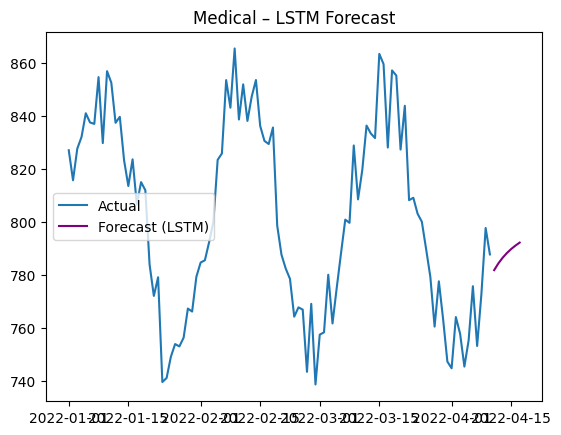

In [ ]:
# B2:- LSTM Model on ECG RR Intervals (Heartbeat Timing)

# Step 1: Normalize the RR interval data to the range [0, 1]
scaler_med = MinMaxScaler()
scaled_med = scaler_med.fit_transform(series_med.values.reshape(-1, 1))
# Reshape required as scaler expects 2D array; scaled_med contains normalized RR intervals

# Step 2: Create sequences of past values as input and the next value as the target
X_med, y_med = [], []
for i in range(window, len(scaled_med)):  # Use same window size as in finance model (30 days)
    X_med.append(scaled_med[i-window:i])   # Sequence of 30 RR intervals
    y_med.append(scaled_med[i])            # Target: next RR interval
X_med, y_med = np.array(X_med), np.array(y_med)  # Convert to NumPy arrays for LSTM compatibility

# Step 3: Build the LSTM model
from tensorflow.keras.layers import Input  # Added: Input layer for defining input shape cleanly

model_med = Sequential()
model_med.add(Input(shape=(X_med.shape[1], 1)))  # Explicit Input layer to avoid input_shape warning
model_med.add(LSTM(50))                          # 50 LSTM units; input shape is already defined
model_med.add(Dense(1))                          # Output layer: predicts one value
model_med.compile(loss='mse', optimizer='adam')  # Compile with Mean Squared Error loss

# Train the model for 10 epochs quietly with a batch size of 16
model_med.fit(X_med, y_med, epochs=10, batch_size=16, verbose=0)

# Step 4: Forecast the next 7 days of RR intervals
input_seq = scaled_med[-window:].reshape(1, window, 1)  # Start with the last 30 known RR intervals
forecast_med_lstm = []  # Empty list to store predictions

for _ in range(7):
    next_val = model_med.predict(input_seq, verbose=0)[0][0]  # Predict next value
    forecast_med_lstm.append(next_val)                        # Store predicted value
    input_seq = np.append(input_seq[:, 1:, :], [[[next_val]]], axis=1)  # Slide window forward

# Step 5: Inverse scale the forecast to original RR interval values
forecast_med_lstm = scaler_med.inverse_transform(np.array(forecast_med_lstm).reshape(-1, 1))

# Step 6: Plot actual and predicted RR intervals
plt.plot(series_med, label='Actual')  # Plot original RR interval series
plt.plot(pd.date_range(series_med.index[-1], periods=8, freq='D')[1:], forecast_med_lstm,
         label='Forecast (LSTM)', color='purple')  # Plot 7-day forecast
plt.title('Medical – LSTM Forecast')
plt.legend()
plt.show()

# Interpretation:
# - LSTM uses past 30 days of RR interval data to learn and predict future heartbeat patterns.
# - It captures nonlinear relationships and subtle changes in physiological behavior.
# - The forecast gives a data-driven estimate .of the next 7 days of cardiac activity.
# - This can be useful in personalized health monitoring or stress level detection.
# - Compared to ARIMA, LSTM adapts better to irregular rhythms often seen in medical data.


Medical (RR Intervals): MAE - ARIMA: 33.19, LSTM: 19.91
Medical (RR Intervals): RMSE - ARIMA: 37.32, LSTM: 23.50


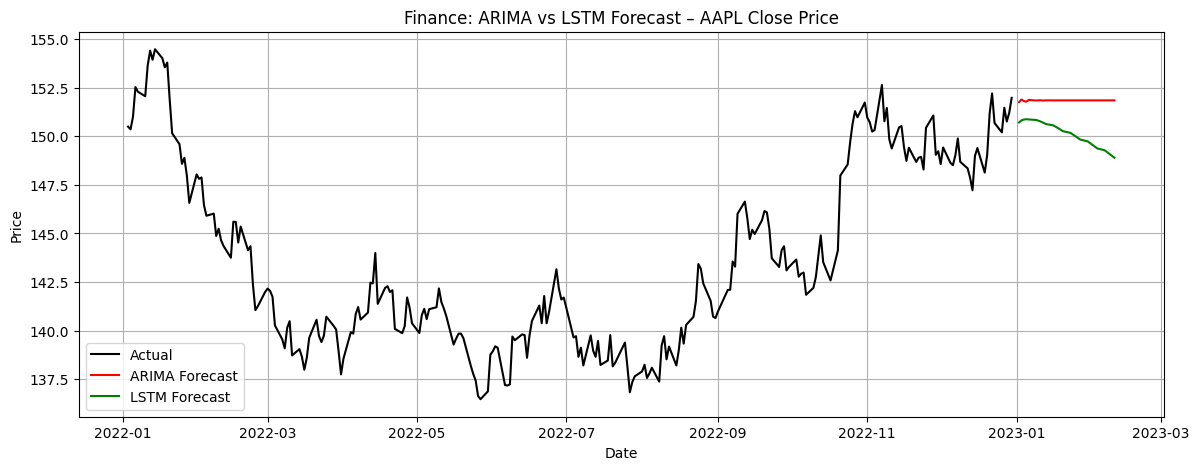

In [ ]:
# PART C – Comparison of ARIMA vs LSTM on Medical Time-Series (ECG RR Intervals)

# Evaluation using error metrics: MAE (Mean Absolute Error) and RMSE (Root Mean Squared Error)

# Step 1: Extract true values and predictions
true_vals_med = series_med[-7:].values
arima_vals_med = forecast_med_arima.values
lstm_vals_med = forecast_med_lstm.flatten()

# Step 2: Compute MAE and RMSE for medical use case
mae_arima = mean_absolute_error(true_vals_med, arima_vals_med)
rmse_arima = np.sqrt(mean_squared_error(true_vals_med, arima_vals_med))

mae_lstm = mean_absolute_error(true_vals_med, lstm_vals_med)
rmse_lstm = np.sqrt(mean_squared_error(true_vals_med, lstm_vals_med))

# Step 3: Print results
print(f"Medical (RR Intervals): MAE - ARIMA: {mae_arima:.2f}, LSTM: {mae_lstm:.2f}")
print(f"Medical (RR Intervals): RMSE - ARIMA: {rmse_arima:.2f}, LSTM: {rmse_lstm:.2f}")


# ===========================
# Finance Data – Visual Comparison
# ===========================

plt.figure(figsize=(14, 5))

# Actual stock prices
plt.plot(series_fin, label='Actual', color='black')

# ARIMA Forecast
plt.plot(pd.date_range(series_fin.index[-1], periods=31, freq='B')[1:],
         forecast_fin_arima.values, label='ARIMA Forecast', color='red')

# LSTM Forecast
plt.plot(pd.date_range(series_fin.index[-1], periods=31, freq='B')[1:],
         forecast_fin_lstm.flatten(), label='LSTM Forecast', color='green')

plt.title('Finance: ARIMA vs LSTM Forecast – AAPL Close Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

# Interpretation:
# - Both models forecast 30 days ahead based on historical AAPL stock prices.
# - ARIMA is smoother and follows recent trend linearly.
# - LSTM adapts to nonlinear jumps and short-term fluctuations.
# - Plot helps visually compare model behavior over time.


# - MAE (Mean Absolute Error) represents the **average size of the prediction error**,
#   without considering direction (i.e., absolute difference between predicted and true values).
#   Lower MAE = more accurate on average.

# - RMSE (Root Mean Squared Error) also measures prediction error but gives **more weight to larger errors**
#   due to squaring. It is more sensitive to outliers than MAE.

# - ARIMA: A linear model — **good for stable, slowly changing time-series*                                                                                                                                                                                                                                                        * like periodic RR intervals or trends in stock prices.
#   It is **fast to train, interpretable**, and performs well when assumptions (like stationarity and linearity) hold.

# - LSTM: A deep learning model — **can learn nonlinear and complex temporal patterns** (e.g., sudden volatility in markets or
#   physiological stress responses). It requires **more data and tuning**, but often **outperforms ARIMA** in dynamic settings.

# Bottom Line:
# - Use **ARIMA** for quick, transparent forecasts on simpler patterns.
# - Use **LSTM** for complex, noisy, or nonlinear time-series signals.
